# NYC Open Data - Street Trees Spatial Join

1. Data Ingestion
2. Spatial Join
3. Aggregating data by osmid 

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import rtree

from shapely.geometry import Point, box, Polygon

from fiona.crs import from_epsg
%matplotlib inline

### I. Import shapefiles and convert to appropriate coordinate system

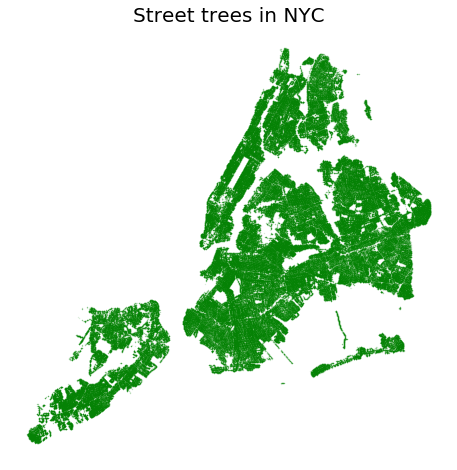

In [2]:
# Ingest data and convert to long island state plane so we can use ft as units
segs = gpd.read_file('../road_network_data/osm/osm_w_collisions/edges/edges.shp').to_crs({'init': 'epsg:2263'})
nodes = gpd.read_file('../road_network_data/osm/osm_w_collisions/nodes/nodes.shp').to_crs({'init': 'epsg:2263'})

# Get schools from CSV
trees = pd.read_csv('2015_Street_Tree_Census_-_Tree_Data.csv')

#Transform to GeoDataFrame
trees['geometry'] = trees.apply(lambda x: Point(x['x_sp'], x['y_sp']), axis=1)
trees = gpd.GeoDataFrame(trees)
trees.crs = from_epsg(2263)

#Remove schools without location (only one)
#trees = trees[~trees.x_sp.isna()]

fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Street trees in NYC', fontsize=20)
#segs.plot(color='black', ax= ax, lw=0.2, zorder=-1)
#nodes.plot(markersize=0.1, ax= ax)
trees.plot(color='green', markersize=0.1, alpha=0.2, ax=ax)
ax.axis('off')

plt.show()

### II. Spatial Join

#### First create an Rtree index to make the search faster

In [3]:
index = rtree.Rtree()
for idx, geometry in enumerate(segs.geometry):
    index.insert(idx, geometry.bounds)

def closest_segment_id_rtree(point, index, segments):
    match = list(index.nearest((point.x, point.y, point.x, point.y)))
    if len(match):
        return segments.loc[segments.loc[match, 'geometry'].distance(point).idxmin(),'id']
    else:
        return None
    
def closest_segment_id(point, segments):
    return segments.loc[segments.geometry.distance(point).idxmin(),'id']

In [4]:
len(segs), len(trees)

(91666, 683788)

In [5]:
%time trees['segid'] = trees.geometry.apply(lambda x: closest_segment_id_rtree(x, index, segs))

CPU times: user 20min 50s, sys: 8.34 s, total: 20min 58s
Wall time: 20min 58s


In [6]:
trees.segid.isna().sum()

0

All schools are matched to a segment

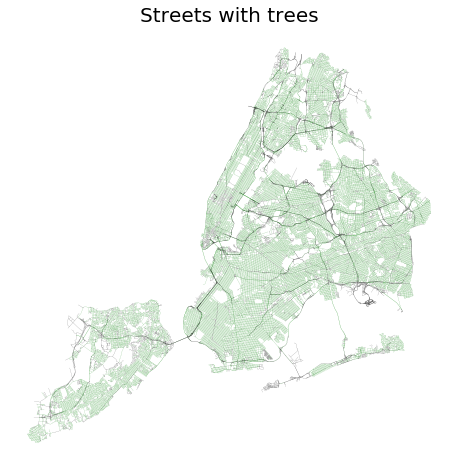

In [7]:
# visualize joined data (zoomed in)
fig, ax = plt.subplots(figsize=(12,8))

matched_segids = trees.segid.unique()

ax.set_title('Streets with trees', fontsize=20)
segs[segs.id.isin(matched_segids)].plot(color='green', ax= ax, lw=0.1, zorder=-1)
segs[~segs.id.isin(matched_segids)].plot(color='black', ax= ax, lw=0.1, zorder=-1)
#nodes.plot(markersize=0.3, ax= ax)
#schools.plot(color='green', markersize=10, ax=ax)

ax.axis('off')

plt.show()

Looks like most streets have trees

### III. Aggregate to SoP variables per segment


In [8]:
# available columns
trees.columns

Index(['tree_id', 'block_id', 'created_at', 'tree_dbh', 'stump_diam',
       'curb_loc', 'status', 'health', 'spc_latin', 'spc_common', 'steward',
       'guards', 'sidewalk', 'user_type', 'problems', 'root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other',
       'brch_light', 'brch_shoe', 'brch_other', 'address', 'postcode',
       'zip_city', 'community board', 'borocode', 'borough', 'cncldist',
       'st_assem', 'st_senate', 'nta', 'nta_name', 'boro_ct', 'state',
       'latitude', 'longitude', 'x_sp', 'y_sp', 'council district',
       'census tract', 'bin', 'bbl', 'geometry', 'segid'],
      dtype='object')

#### 1. strttree: How many street trees are on the segment? 

Answer should be:

- Some/A lot: 2
- Few: 1
- None: 0

In [9]:
final_df = trees.groupby('segid')[['tree_id']].nunique()
final_df.rename(columns={'tree_id':'n_trees'}, inplace=True)
final_df.head()

,n_trees
segid,
2,4
3,2
5,11
6,16
7,9


In [10]:
final_df.describe()

,n_trees
count,66821.000000
mean,10.233130
std,10.137711
min,1.000000
25%,4.000000
50%,7.000000
75%,14.000000
max,602.000000


In [12]:
final_df.sort_values('n_trees', ascending=False).head(10)

,n_trees
segid,
89707,602
62014,474
46944,202
54884,180
5390,172
76016,169
15435,169
82689,155
77056,154


In [13]:
final_df.to_csv('joined_n_trees.csv')

In [10]:
#Few is up to 3.
few = 3
final_df['strttree'] = final_df.n_trees.apply(lambda x: 2 if x > few else 1 if x > 0 else 0)
final_df.head()

,n_trees,strttree
segid,,
2,4,2
3,2,1
5,11,2
6,16,2
7,9,2


In [11]:
# # bin trees. Using the mean number of trees as cut between few and some/a lot.
# cats = [0,1,2]
# final_df['strttree'] = pd.cut(final_df.n_trees, [0,final_df.n_trees.min(),final_df.n_trees.mean(),final_df.n_trees.max()],
#                                   labels=cats)
# final_df.head()

#### 2. buffsttr: Are any of the following BUFFERS present between the sidewalk or street: Street trees

Answer should be:

- Both Sides: 2
- One Side: 1
- No: 0

Street trees are not necessarily buffers (placed between street and sidewalk)

The tree census includes curb_loc variable, I think this indicates what we need:

curb_loc: Location of tree bed in relationship to the curb; trees are either along the curb (OnCurb) or offset from the curb (OffsetFromCurb). A tree identified as being on the curb will have the point placed 2.5 feet from the blockface line; a tree identified as being offset will have the point placed 12 feet from the curb line.

In [12]:
trees.curb_loc.value_counts()

OnCurb            656896
OffsetFromCurb     26892
Name: curb_loc, dtype: int64

Well... Most of them are OnCurb anyways.

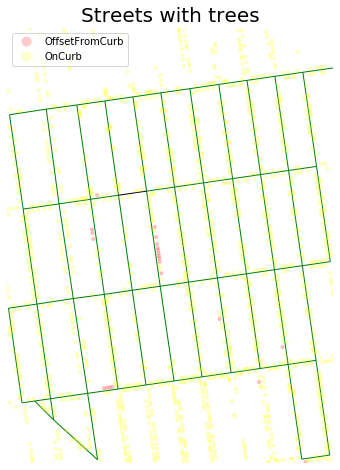

In [13]:
# visualize joined data (zoomed in)
fig, ax = plt.subplots(figsize=(12,8))

#Set a boundary to plot part of the city
minx, miny, maxx, maxy = (996000, 164000, 999000, 168000)
sample_bounds = box(minx, miny, maxx, maxy)
trees_sample = trees[trees.within(sample_bounds)]
segs_sample = segs[segs.within(sample_bounds)]

matched_segids = trees_sample.segid.unique()

ax.set_title('Streets with trees', fontsize=20)
trees_sample.plot(column='curb_loc', markersize=10, alpha=0.2, ax=ax, legend=True, cmap='autumn')
segs_sample[segs_sample.id.isin(matched_segids)].plot(color='green', ax= ax, lw=1, zorder=-1)
segs_sample[~segs_sample.id.isin(matched_segids)].plot(color='black', ax= ax, lw=1, zorder=-1)
#nodes.plot(markersize=0.3, ax= ax)
#schools.plot(color='green', markersize=10, ax=ax)

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

ax.axis('off')

plt.show()

Need to do a right and left buffers separately

In [14]:
buff = 30

segs_sample_buff_r = segs_sample.copy()
segs_sample_buff_r['geometry'] = segs_sample_buff_r.geometry.apply(lambda x: x.parallel_offset(buff, 'right').buffer(buff, cap_style=2))
segs_sample_buff_l = segs_sample.copy()
segs_sample_buff_l['geometry'] = segs_sample_buff_l.geometry.apply(lambda x: x.parallel_offset(buff, 'left').buffer(buff, cap_style=2))

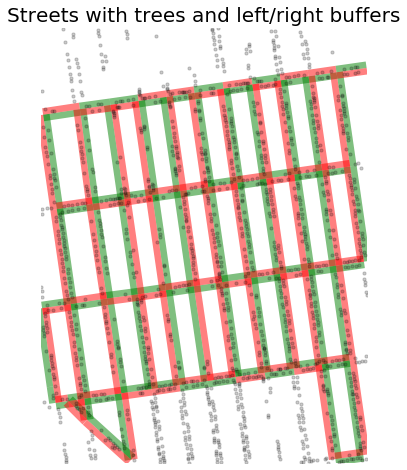

In [15]:
# visualize joined data (zoomed in)
fig, ax = plt.subplots(figsize=(12,8))

matched_segids = trees_sample.segid.unique()

ax.set_title('Streets with trees and left/right buffers', fontsize=20)
trees_sample.plot(color='k', markersize=10, alpha=0.2, ax=ax)
segs_sample_buff_r.plot(color='green', ax= ax, zorder=-1, alpha=.5)
segs_sample_buff_l.plot(color='red', ax= ax, zorder=-1, alpha=.5)
#nodes.plot(markersize=0.3, ax= ax)
#schools.plot(color='green', markersize=10, ax=ax)

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

ax.axis('off')

plt.show()

Apply on the whole city and do spatial join

In [13]:
%%time

buff = 30

#Create right and left buffers
segs_buff_r = segs.copy()
segs_buff_r['geometry'] = segs_buff_r.geometry.apply(lambda x: x.parallel_offset(buff, 'right').buffer(buff, cap_style=2))
segs_buff_l = segs.copy()
segs_buff_l['geometry'] = segs_buff_l.geometry.apply(lambda x: x.parallel_offset(buff, 'left').buffer(buff, cap_style=2))

#Fix empty buffers (ring-like segments where the above didn't work)
empty = segs_buff_r.geometry.apply(lambda x: x.is_empty)
segs_buff_r.loc[empty, 'geometry'] = segs.geometry[empty].apply(lambda x: Polygon(x.coords))
empty = segs_buff_l.geometry.apply(lambda x: x.is_empty)
segs_buff_l.loc[empty, 'geometry'] = segs.geometry[empty].apply(lambda x: Polygon(x.coords))

#Just to avoid a warning
segs_buff_r.crs = from_epsg(2263)
segs_buff_l.crs = from_epsg(2263)

#Use only treeswith curb_loc: OnCurb
trees_curb = trees[trees.curb_loc == 'OnCurb']

#Spatial join
trees_joined_r = gpd.sjoin(segs_buff_r, trees_curb, how='left')
trees_joined_l = gpd.sjoin(segs_buff_l, trees_curb, how='left')

#Groupby segment id
trees_joined_r = trees_joined_r.groupby('id')[['tree_id']].nunique()
trees_joined_r.rename(columns={'tree_id':'n_trees_right'}, inplace=True)
trees_joined_l = trees_joined_l.groupby('id')[['tree_id']].nunique()
trees_joined_l.rename(columns={'tree_id':'n_trees_left'}, inplace=True)

#Join sides
trees_curb_joined = pd.merge(trees_joined_l, trees_joined_r, left_index=True, right_index=True, how='outer').fillna(0).astype(int)
trees_curb_joined.head()

CPU times: user 5min 56s, sys: 8.19 s, total: 6min 4s
Wall time: 6min 4s


In [14]:
trees_curb_joined.head()

,n_trees_left,n_trees_right
id,,
1,0,0
2,0,6
3,1,0
4,1,0
5,4,7


How many trees should we consider to decide if there is a tree barrier or not? More than 1?

In [18]:
trees_curb_joined['buffsttr'] = (trees_curb_joined > 1)[['n_trees_left', 'n_trees_right']].sum(axis=1)
trees_curb_joined.head()

,n_trees_left,n_trees_right,buffsttr
id,,,
1,0,0,0
2,0,6,1
3,1,0,0
4,1,0,0
5,4,7,2


In [19]:
final_df = pd.merge(final_df, trees_curb_joined, right_index=True, left_index=True, how='right').fillna(0).astype(int)
final_df.head()

,n_trees,strttree,n_trees_left,n_trees_right,buffsttr
id,,,,,
1,0,0,0,0,0
2,4,2,0,6,1
3,2,1,1,0,0
4,0,0,1,0,0
5,11,2,4,7,2


**Note:** n_trees calculated in (1) does not allways equal n_trees_left + n_trees_right from (2). Why? In (1) we used all trees and did it by distance (one tree -> one street), but in (2) we used only OnCurb trees and did it with buffer (one tree -> 1 or more streets, specially in corners)

#### 3. sdwkshde: Is the sidewalk shaded by trees?

SoP answers:
* More than 50%: 2
* 25-50%: 1
* Less than 25%: 0


We could get more complicated for this, but for now I'll just assign the same from strttree.

In [21]:
final_df[final_df.n_trees > 0].n_trees.describe()

count    66821.000000
mean        10.233130
std         10.137711
min          1.000000
25%          4.000000
50%          7.000000
75%         14.000000
max        602.000000
Name: n_trees, dtype: float64

In [37]:
final_df['trees_by_meter'] = segs.length / final_df.n_trees
final_df.trees_by_meter.describe()

count    9.166500e+04
mean              inf
std               NaN
min      3.071052e-02
25%      2.810696e+01
50%      8.229757e+01
75%               NaN
max               inf
Name: trees_by_meter, dtype: float64

In [39]:
#1 tree every 20 meters = 50% of shade
final_df['sdwkshde'] = final_df.trees_by_meter.apply(lambda x: 2 if x < 20 else 1 if x < 40 else 0)
final_df.sdwkshde.value_counts()

0    60797
2    16389
1    14480
Name: sdwkshde, dtype: int64

In [40]:
variables = ['strttree', 'buffsttr', 'sdwkshde']
final_df[variables].to_csv('joined_trees.csv')

I think it's better to save the above and then merge everything together into a shapefile when we have all variables. I'll do the merge only to plot.

In [41]:
segs_joined = pd.merge(segs, final_df, left_on='id', right_index=True, how='left').fillna(0)
segs_joined[variables] = segs_joined[variables].astype(int)

#### Plot result

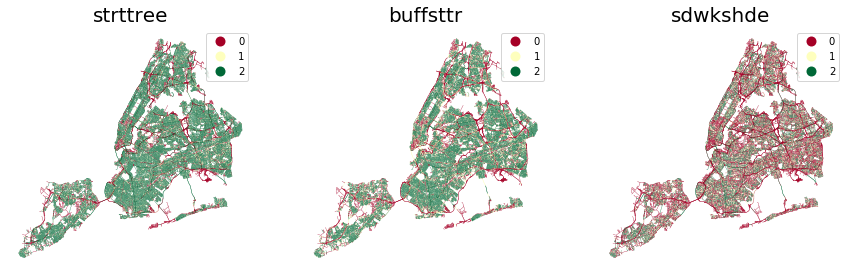

In [42]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,6))

for i, var in enumerate(variables):
    ax = axes.flatten()[i]
    segs_joined.plot(column=var, ax= ax, lw=0.3, zorder=-1, alpha=1, cmap='RdYlGn',legend=True, categorical=True)
    ax.set_title(var, fontsize=20)
    ax.axis('off')

plt.show()

In [43]:
final_df[variables].describe()

,strttree,buffsttr,sdwkshde
count,91666.000000,91666.000000,91666.000000
mean,1.280737,1.183896,0.515546
std,0.862559,0.856082,0.779324
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000
75%,2.000000,2.000000,1.000000
max,2.000000,2.000000,2.000000
